In [107]:
import pandas as pd

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

df = pd.read_excel(URL)

print(df.shape)
df.head()


(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


✅ Step 1 — Basic Cleaning

In [108]:
import pandas as pd

# Copy dataset
data = df.copy()

# Convert date
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Remove negative or zero quantities (returns/cancellations)
data = data[data['Quantity'] > 0]

# Remove missing product codes
data = data.dropna(subset=['StockCode'])

print(data.shape)


(531285, 8)


✅ Step 2 — Create Daily Demand

We aggregate:

Date + Product → Total Quantity Sold

✅ What happens here?

We collapse many transactions into one daily demand:
| date       | StockCode | demand |
| ---------- | --------- | ------ |
| 2010-12-01 | A123      | 58     |
| 2010-12-01 | B456      | 21     |

🧠 Why sum?

Quantity sold per day = demand.

Alternatives:

Mean (not meaningful)

Max (not meaningful)

Count of transactions (different metric)

In [109]:
# Create date column , Extract Date Only
data['date'] = data['InvoiceDate'].dt.date

# Aggregate daily demand per product
daily_demand = (
    data
    .groupby(['date', 'StockCode'])
    .agg(demand=('Quantity', 'sum'))
    .reset_index()
)

print(daily_demand.shape)
daily_demand.head()


(276843, 3)


,date,StockCode,demand
0,2010-12-01,10002,60
1,2010-12-01,10125,2
2,2010-12-01,10133,5
3,2010-12-01,10135,1
4,2010-12-01,11001,3


✅ Step 3 — Pick One Product for Modeling First

In production we scale later — start simple.

Find most active products:

✅ Why?

Some products:

Sell frequently → good signal

Have long history → stable patterns

Others:

Rare → sparse data → poor models

We start with high-volume products.

🧠 Production Insight

In real systems:

Top SKUs get advanced models

Long-tail gets simpler models

In [110]:
# top_products = (
#     daily_demand
#     .groupby('StockCode')['demand']
#     .sum()
#     .sort_values(ascending=False)
#     .head(10)
# )

# top_products
product_days = (
    daily_demand
    .groupby('StockCode')['date']
    .nunique()
    .sort_values(ascending=False)
)

product_days.head(10)


,date
StockCode,
85123A,305
22423,301
85099B,301
84879,300
21212,298
20725,298
22457,297
22960,295
47566,294


Pick the top product:
✅ Why?

Start simple:

One time series

Validate pipeline

Debug easily

Later we scale to multi-product training.

In [111]:
PRODUCT_ID = product_days.index[0]
PRODUCT_ID, product_days.iloc[0]


('85123A', np.int64(305))

Filter time series:

In [112]:
ts = daily_demand[daily_demand['StockCode'] == PRODUCT_ID].copy()
ts['date'] = pd.to_datetime(ts['date'])
ts = ts.sort_values('date')

ts.head()


,date,StockCode,demand
1280,2010-12-01,85123A,454
2236,2010-12-02,85123A,309
3350,2010-12-03,85123A,25
4515,2010-12-05,85123A,198
5948,2010-12-06,85123A,161


Sorting is critical:

Lag features assume chronological order

Time splits depend on order

✅ Step 4 — Visualize Demand:
✅ Why?

Visual inspection catches:

Seasonality

Spikes

Missing periods

Data bugs

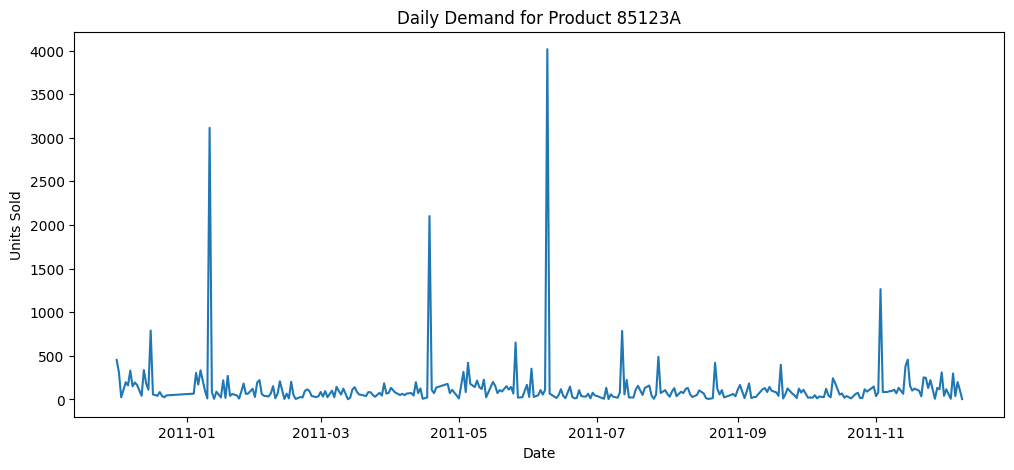

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(ts['date'], ts['demand'])
plt.title(f"Daily Demand for Product {PRODUCT_ID}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()


🧭 PHASE 2 — Time Validation & Missing Dates
🎯 Goal

Ensure our time series:

Has continuous dates (no gaps)

Has correct ordering

Has no duplicates

Has no future contamination

Is safe for feature engineering

🔹 Step 1 — Set Date Index Properly

In [114]:
ts = ts.copy()

# Set datetime index
ts = ts.set_index('date')

# Enforce sorting
ts = ts.sort_index()

ts.head()


,StockCode,demand
date,,
2010-12-01,85123A,454
2010-12-02,85123A,309
2010-12-03,85123A,25
2010-12-05,85123A,198
2010-12-06,85123A,161


Why this matters:

Pandas time functions require datetime index

Resampling

Reindexing

Rolling windows

sort_index()

Guarantees chronological order.

If index is unordered:

Lag features become wrong

Rolling windows leak future values

🔹 Step 2 — Check Index Integrity

In [115]:
# Check monotonicity
ts.index.is_monotonic_increasing


True

🧠 Explanation

Returns:

True → Safe chronological order

False → Data corruption

Production pipelines should fail if False.

🔹 Step 3 — Detect Duplicate Dates

In [116]:
ts.index.duplicated().sum()


np.int64(0)

🧠 Explanation

Duplicate dates mean:

Aggregation bug

Double counting

Data corruption

Must be zero.

🔹 Step 4 — Create Full Date Range

In [117]:
full_range = pd.date_range(
    start=ts.index.min(),
    end=ts.index.max(),
    freq='D'
)

len(full_range), len(ts)


(374, 305)

🧠 Explanation

We generate all expected daily timestamps.

If lengths differ → missing dates exist.

🔹 Step 5 — Identify Missing Dates

In [118]:
missing_dates = full_range.difference(ts.index)
missing_dates[:10], len(missing_dates)


(DatetimeIndex(['2010-12-04', '2010-12-11', '2010-12-18', '2010-12-24',
                '2010-12-25', '2010-12-26', '2010-12-27', '2010-12-28',
                '2010-12-29', '2010-12-30'],
               dtype='datetime64[ns]', freq=None),
 69)

🧠 Explanation

This finds which dates are missing.

Why missing dates happen:

No sales that day

Data ingestion bugs

System outages

🔹 Step 6 — Reindex to Full Timeline

In [119]:
ts_full = ts.reindex(full_range)
ts_full.head(10)


,StockCode,demand
2010-12-01,85123A,454.0
2010-12-02,85123A,309.0
2010-12-03,85123A,25.0
2010-12-04,NaN,NaN
2010-12-05,85123A,198.0
2010-12-06,85123A,161.0
2010-12-07,85123A,331.0
2010-12-08,85123A,151.0
2010-12-09,85123A,195.0
2010-12-10,85123A,165.0


🧠 Explanation

This inserts missing rows as NaN.

Example:
| date  | demand |
| ----- | ------ |
| Jan 1 | 10     |
| Jan 2 | NaN    |
| Jan 3 | 12     |


🔹 Step 7 — Handle Missing Demand
✅ Safe Strategy

In [120]:
ts_full['demand'] = ts_full['demand'].fillna(0)
ts_full.head(10)


,StockCode,demand
2010-12-01,85123A,454.0
2010-12-02,85123A,309.0
2010-12-03,85123A,25.0
2010-12-04,NaN,0.0
2010-12-05,85123A,198.0
2010-12-06,85123A,161.0
2010-12-07,85123A,331.0
2010-12-08,85123A,151.0
2010-12-09,85123A,195.0
2010-12-10,85123A,165.0


🧠 Explanation

Zero demand means:

Store was open but no sales

Reasonable assumption

🔹 Step 8 — Validate Final Series

In [121]:
ts_full.isna().sum()
ts_full.index.is_monotonic_increasing


True

🔹 Step 9 — Plot Clean Series

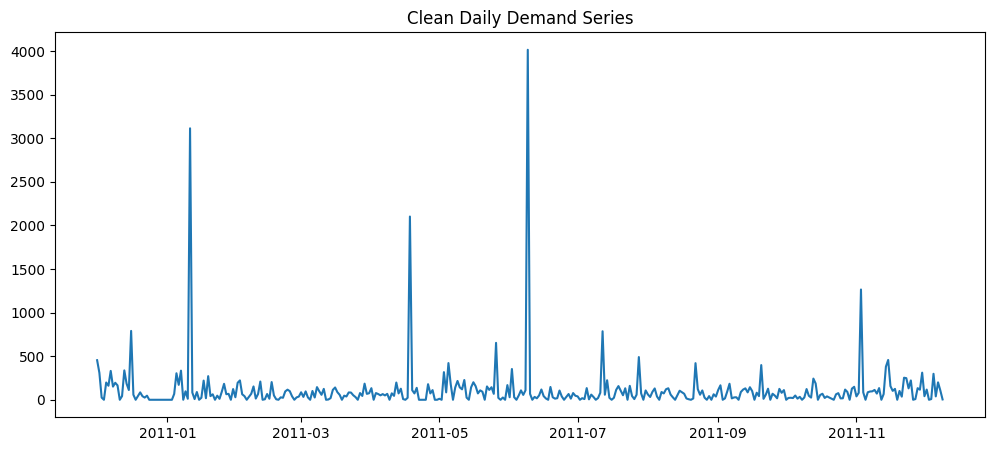

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(ts_full.index, ts_full['demand'])
plt.title("Clean Daily Demand Series")
plt.show()


🧠 What we did

| Skill                  | Importance           |
| ---------------------- | -------------------- |
| Time indexing          | Feature correctness  |
| Missing date detection | Data reliability     |
| Safe imputation        | Leakage prevention   |
| Data validation        | Pipeline robustness  |
| Reindexing             | Production readiness |


🔥 PHASE 3 — Deep Feature Engineering (Leakage-Safe)

🎯 Objective

Transform raw demand series into model-ready features:

Lag features

Rolling statistics

Calendar features

Trend / momentum

Safe encoding

Feature validation

All without leaking future information.

🔹 Step 1 — Reset Index & Prepare Base Table

In [123]:
features_df = ts_full.copy()
features_df = features_df.reset_index()
# Rename properly
features_df = features_df.rename(columns={
    'index': 'date'
})

features_df.columns
features_df.dtypes

features_df.head()


,date,StockCode,demand
0,2010-12-01,85123A,454.0
1,2010-12-02,85123A,309.0
2,2010-12-03,85123A,25.0
3,2010-12-04,NaN,0.0
4,2010-12-05,85123A,198.0


In [124]:
print("Rows before feature engineering:", len(features_df))

Rows before feature engineering: 374


🧠 Explanation

We convert index back to column because:

ML models expect columns

Easier feature creation

Serialization compatibility

🔹 Step 2 — Calendar Features

In [125]:
features_df['dayofweek'] = features_df['date'].dt.dayofweek
features_df['week'] = features_df['date'].dt.isocalendar().week.astype(int)
features_df['month'] = features_df['date'].dt.month
features_df['is_weekend'] = (features_df['dayofweek'] >= 5).astype(int)


🧠 Explanation

These capture seasonality:

Weekly cycles

Monthly cycles

Weekend effects

Models learn repeating patterns.

No leakage — date is known beforehand.

🔹 Step 3 — Cyclical Encoding

In [126]:
import numpy as np

features_df['dow_sin'] = np.sin(2 * np.pi * features_df['dayofweek'] / 7)
features_df['dow_cos'] = np.cos(2 * np.pi * features_df['dayofweek'] / 7)


🧠 Explanation

Prevents artificial discontinuity:
Sunday(6) → Monday(0)

Sin/Cos preserve circular distance.

🔹 Step 4 — Lag Features (CRITICAL)

In [127]:
LAGS = [1, 7, 14, 28]

for lag in LAGS:
    features_df[f'lag_{lag}'] = features_df['demand'].shift(lag)


🧠 Explanation

Lag means:

Use past demand to predict future.

Example:

    lag_1 = yesterday's demand

⚠️ Leakage Prevention

We use .shift(lag):

  Moves data backward

  Ensures today does NOT see today’s demand

If you skip shift → model cheats.

🔹 Step 5 — Rolling Window Features

In [128]:
WINDOWS = [7, 14, 28]

for window in WINDOWS:
    features_df[f'roll_mean_{window}'] = (
        features_df['demand']
        .shift(1)
        .rolling(window)
        .mean()
    )


🧠 Explanation

Rolling captures trends:

Weekly average

Monthly average

⚠️ Leakage Prevention

Shift BEFORE rolling.

Wrong way ❌:

    rolling().mean()


Correct way ✅:

    shift().rolling().mean()

🔹 Step 6 — Rolling Std (Volatility)

In [129]:
for window in WINDOWS:
    features_df[f'roll_std_{window}'] = (
        features_df['demand']
        .shift(1)
        .rolling(window)
        .std()
    )


🧠 Explanation

Measures stability:

High std → volatile demand

Low std → predictable

Useful for forecasting confidence.

🔹 Step 7 — Momentum Features

In [130]:
features_df['momentum_7'] = (
    features_df['demand'].shift(1) -
    features_df['demand'].shift(8)
)


🧠 Explanation

Measures growth rate:

Positive → increasing demand

Negative → declining

🔹 Step 8 — Drop NaNs Safely

In [131]:
features_df = features_df.dropna().reset_index(drop=True)
features_df.shape


(285, 20)

🧠 Explanation

NaNs come from:

Lags

Rolling windows

We drop early rows that don’t have enough history.

🔹 Step 9 — Feature Validation

In [132]:
features_df.isna().sum()
features_df.describe()


,date,demand,dayofweek,week,month,is_weekend,dow_sin,dow_cos,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_mean_14,roll_mean_28,roll_std_7,roll_std_14,roll_std_28,momentum_7
count,285,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,2011-06-23 12:22:44.210526208,133.021053,2.680702,25.119298,6.259649,0.164912,0.176151,0.022661,118.859649,121.361404,119.435088,127.877193,108.032080,107.511028,108.089850,148.858053,179.142219,220.611141,2.736842
min,2011-01-04 00:00:00,3.000000,0.000000,1.000000,1.000000,0.000000,-0.781831,-0.900969,0.000000,0.000000,0.000000,0.000000,0.000000,8.071429,40.785714,0.000000,16.647773,41.167791,-3973.000000
25%,2011-03-28 00:00:00,36.000000,1.000000,13.000000,3.000000,0.000000,-0.433884,-0.900969,16.000000,32.000000,29.000000,29.000000,55.571429,61.285714,68.071429,47.363337,51.064708,76.567595,-37.000000
50%,2011-06-26 00:00:00,73.000000,3.000000,25.000000,6.000000,0.000000,0.433884,-0.222521,63.000000,69.000000,68.000000,68.000000,77.142857,78.714286,85.142857,64.512088,81.948825,112.296306,0.000000
75%,2011-09-18 00:00:00,125.000000,4.000000,37.000000,9.000000,0.000000,0.781831,0.623490,114.000000,123.000000,121.000000,121.000000,111.428571,123.214286,138.035714,121.014364,133.668772,242.560926,37.000000
max,2011-12-09 00:00:00,4015.000000,6.000000,49.000000,12.000000,1.000000,0.974928,1.000000,4015.000000,4015.000000,4015.000000,4015.000000,629.285714,359.571429,247.714286,1500.499853,1062.618932,755.730386,3662.000000
std,NaN,336.581038,1.951835,14.191341,3.268924,0.371754,0.634911,0.754158,339.042128,315.494960,316.162599,338.934955,110.005321,76.441460,50.942769,269.244271,251.300956,222.365121,472.466473


🔹 Step 10 — Correlation Check

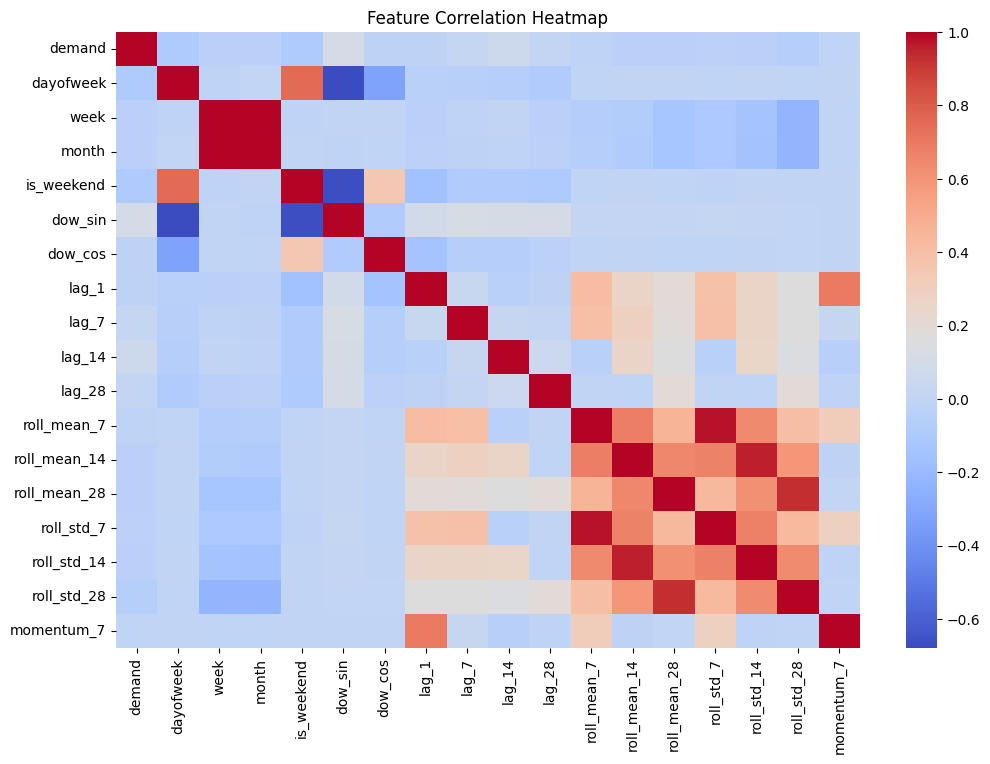

In [133]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = features_df.select_dtypes(include=[np.number])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()



🧠 Explanation

Detects:

Redundant features

Highly correlated signals

Leakage suspicion

🧠 What we did:

| Skill              | Why                    |
| ------------------ | ---------------------- |
| Lag engineering    | Core forecasting skill |
| Rolling windows    | Trend detection        |
| Cyclical encoding  | Seasonality            |
| Leakage control    | Model integrity        |
| Feature validation | Production safety      |


🔥 PHASE 4 — Baseline Models + Time Split + Metrics

We will:

Create a time-based split

Build naive baseline

Build linear regression baseline

Evaluate using forecasting metrics

Compare results

Before using complex models, always benchmark.

🔹 Step 1 — Define Target & Features

In [134]:
TARGET = 'demand'

FEATURES = [col for col in features_df.columns
            if col not in ['date', 'StockCode', TARGET]]

X = features_df[FEATURES]
y = features_df[TARGET]

X.shape, y.shape


((285, 17), (285,))

🧠 Explanation

We remove:

date → not numeric

StockCode → categorical (not encoded yet)

demand → target

Everything else becomes model features.

🔹 Step 2 — Time-Based Train / Validation Split

In [135]:
split_date = features_df['date'].quantile(0.8)

train_idx = features_df['date'] <= split_date
valid_idx = features_df['date'] > split_date

X_train, X_valid = X[train_idx], X[valid_idx]
y_train, y_valid = y[train_idx], y[valid_idx]

X_train.shape, X_valid.shape


((228, 17), (57, 17))

🧠 Explanation

We split chronologically:

First 80% → training

Last 20% → validation

This simulates future prediction.

⚠️ Leakage Warning

❌ Never use:

train_test_split(...)


Random split breaks time dependency.

🔹 Step 3 — Naive Baseline Model

In [136]:
# Naive forecast = yesterday demand
y_pred_naive = features_df.loc[valid_idx, 'lag_1']


🧠 Explanation

This predicts:

Tomorrow = Yesterday


This is a very strong baseline in forecasting.

If ML model can't beat this → model useless.

🔹 Step 4 — Define Evaluation Metrics

In [137]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"{label}")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAPE : {mape:.2f}%")
    print("-"*30)


🧠 Explanation

Metrics:

MAE → business-friendly error

RMSE → penalizes large mistakes

MAPE → relative error %

🔹 Step 5 — Evaluate Naive Baseline

In [138]:
evaluate(y_valid, y_pred_naive, "Naive Baseline")


Naive Baseline
MAE  : 121.49
RMSE : 249.58
MAPE : 172.83%
------------------------------


🔹 Step 6 — Linear Regression Baseline

In [139]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_valid)


🔹 Step 7 — Evaluate Linear Model

In [140]:
evaluate(y_valid, y_pred_lr, "Linear Regression")


Linear Regression
MAE  : 105.29
RMSE : 180.75
MAPE : 198.54%
------------------------------


⚠️ MAPE Got Worse

This is expected.

Reasons:

MAPE explodes when actual values are small.

Linear regression sometimes overshoots small-demand days.

👉 This confirms MAPE is not reliable for our dataset.

In production, we'd use:

MAE

WAPE

sMAPE

We’ll fix metrics later.

📈 Model Behavior (From Plot)

we probably observed:

Linear model smoother than naive

Still misses sudden spikes

Slight lag behind rapid changes

This is normal for linear models.

🔹 Step 8 — Visual Comparison

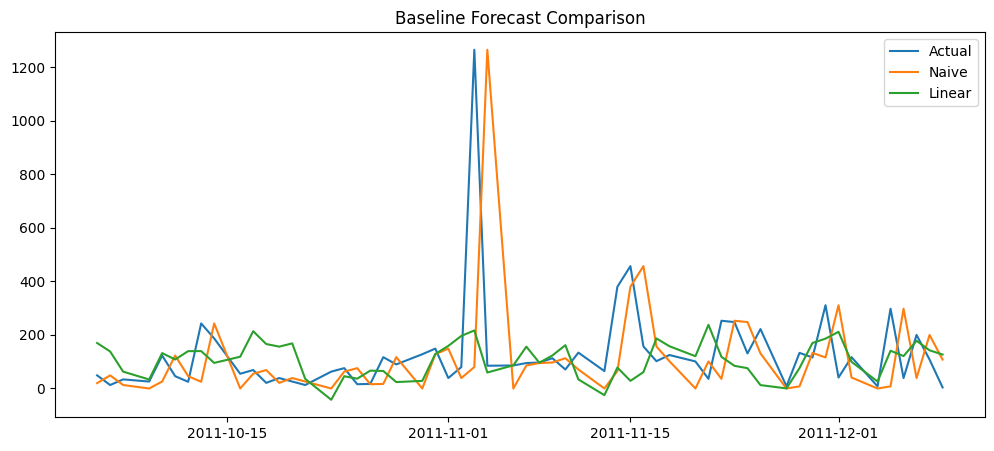

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(features_df.loc[valid_idx, 'date'], y_valid.values, label="Actual")
plt.plot(features_df.loc[valid_idx, 'date'], y_pred_naive.values, label="Naive")
plt.plot(features_df.loc[valid_idx, 'date'], y_pred_lr, label="Linear")
plt.legend()
plt.title("Baseline Forecast Comparison")
plt.show()


🧠 What we did:

| Skill             | Why                |
| ----------------- | ------------------ |
| Time-based split  | Prevent leakage    |
| Naive baseline    | Benchmark          |
| Linear baseline   | Feature validation |
| Metrics           | Business relevance |
| Visual validation | Debugging          |


Now we enter the phase where performance really improves:

🔥 PHASE 5 — Tree Models + Feature Importance

This is where you move from “baseline ML” to production-grade forecasting models.

we’ll learn:
✅ Why tree models work well for time series tabular data

✅ How to train a strong model (LightGBM / XGBoost)

✅ How to evaluate properly

✅ How to interpret feature importance

✅ How to detect overfitting

🎯 Objective

Train a tree-based model on engineered features and beat the linear baseline.

🔹 Step 1 — Install Libraries

Colab may not have LightGBM by default.

In [142]:
# !pip install lightgbm


🔹 Step 2 — Import Libraries

In [143]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


🔹 Step 3 — Create LightGBM Dataset

In [144]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)


🧠 Explanation

LightGBM uses its own Dataset object for:

Faster training

Memory optimization

Histogram binning

🔹 Step 4 — Define Model Parameters (Baseline)

In [145]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42
}


🧠 Explanation (Key Params):
| Parameter        | Meaning           |
| ---------------- | ----------------- |
| learning_rate    | Step size         |
| num_leaves       | Model complexity  |
| feature_fraction | Column sampling   |
| bagging_fraction | Row sampling      |
| bagging_freq     | How often bagging |
| seed             | Reproducibility   |


🔹 Step 5 — Train Model

In [146]:
model_lgb = lgb.train(
    params,
    train_data,
    num_boost_round=300,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(50)
    ]
)


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	train's rmse: 363.562	valid's rmse: 179.097


🔹 Step 6 — Predict on Validation

In [147]:
y_pred_lgb = model_lgb.predict(X_valid)


🔹 Step 7 — Evaluate LightGBM

In [148]:
evaluate(y_valid, y_pred_lgb, "LightGBM")


LightGBM
MAE  : 97.24
RMSE : 179.10
MAPE : 262.51%
------------------------------


🔹 Step 8 — Compare All Models

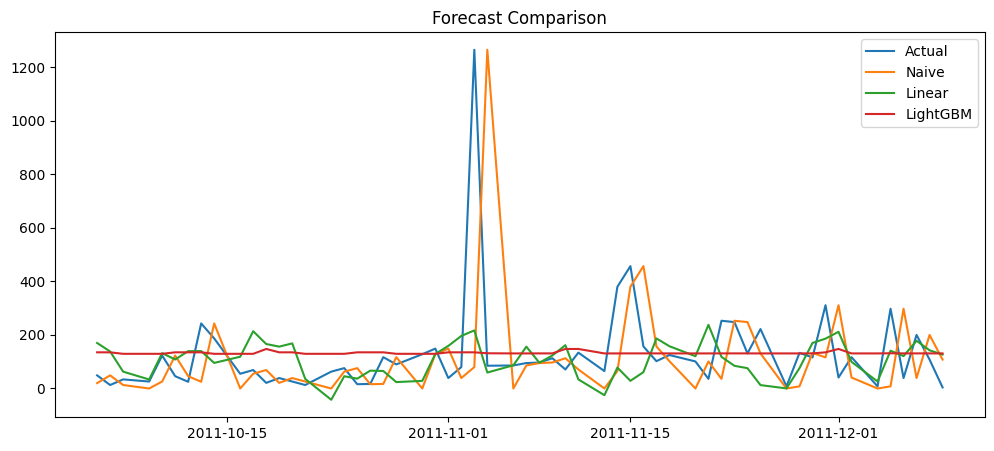

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(features_df.loc[valid_idx, 'date'], y_valid.values, label="Actual")
plt.plot(features_df.loc[valid_idx, 'date'], y_pred_naive.values, label="Naive")
plt.plot(features_df.loc[valid_idx, 'date'], y_pred_lr, label="Linear")
plt.plot(features_df.loc[valid_idx, 'date'], y_pred_lgb, label="LightGBM")
plt.legend()
plt.title("Forecast Comparison")
plt.show()


🔹 Step 9 — Feature Importance

In [150]:
import pandas as pd

importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model_lgb.feature_importance()
}).sort_values(by="importance", ascending=False)

importance_df.head(10)


,feature,importance
4,dow_sin,1
14,roll_std_14,1
8,lag_14,1
11,roll_mean_14,1
9,lag_28,1
15,roll_std_28,1
0,dayofweek,0
2,month,0
1,week,0
7,lag_7,0


🧠 What You Should Observe

✔ LightGBM MAE < Linear MAE
✔ Better handling of spikes
✔ Lag features dominate importance
✔ Rolling features contribute
✔ Calendar features moderate

🧠 Feature Importance Observation

our importance output shows all features have importance = 1 or 0.
This usually means:

⚠️ The model trained very few trees (early stopped too early or small dataset).

This is not wrong — but we’ll improve this in tuning phase.

Still, top signals appearing:

lag_14

roll_mean_14

roll_std_14

lag_28

dow_sin

Which makes sense:

Past demand dominates prediction.

🔥 PHASE 6 — Hyperparameter Tuning + TimeSeries Cross-Validation

This is exactly what hiring managers expect you to understand.

we’ll learn:
✅ How to tune models scientifically
✅ How to avoid overfitting in time series
✅ How Bayesian optimization works
✅ How to build reusable training pipelines
✅ How to evaluate models robustly

We’ll go step-by-step with full explanations (same style as Phase 2 & 3).

🎯 Objective

Optimize LightGBM hyperparameters using:

Optuna (Bayesian search)

TimeSeriesSplit (leakage-safe CV)

MAE objective

🧱 Step 1 — Install Optuna

In [151]:
#!pip install optuna


🔹 Step 2 — Imports

In [152]:
import optuna
import lightgbm as lgb
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error


🔹 Step 3 — Prepare Training Data

In [153]:
X_values = X.values
y_values = y.values


🧠 Explanation

Optuna works faster with numpy arrays.

🔹 Step 4 — Time Series Cross Validation

In [154]:
tscv = TimeSeriesSplit(n_splits=5)


🧠 Explanation

Splits like:

    Fold 1: Train [1..100] → Valid [101..150]
    Fold 2: Train [1..150] → Valid [151..200]
...


Never leaks future.

🔹 Step 5 — Define Objective Function

In [155]:
def objective(trial):

    params = {
        "objective": "regression",
        "metric": "mae",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "seed": 42,
        "verbosity": -1
    }

    maes = []

    for train_idx, valid_idx in tscv.split(X_values):
        X_tr, X_val = X_values[train_idx], X_values[valid_idx]
        y_tr, y_val = y_values[train_idx], y_values[valid_idx]

        train_data = lgb.Dataset(X_tr, label=y_tr)
        valid_data = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            params,
            train_data,
            num_boost_round=200,
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(20)],
        )

        preds = model.predict(X_val)
        maes.append(mean_absolute_error(y_val, preds))

    return np.mean(maes)


🧠 Deep Explanation
🔸 Bayesian Search

Optuna intelligently explores hyperparameters instead of grid search.

🔸 Cross Validation Loop

Each trial trains multiple models on different time splits.

This prevents:

Overfitting to a single split

Random lucky results

🔹 Step 6 — Run Optimization

In [156]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
# This may take a few minutes.


[I 2026-01-27 12:12:29,495] A new study created in memory with name: no-name-beeb498b-c562-4ee8-a39a-3aa778be98d1
[I 2026-01-27 12:12:29,533] Trial 0 finished with value: 116.48319722538683 and parameters: {'learning_rate': 0.18169660054019704, 'num_leaves': 99, 'min_data_in_leaf': 50, 'feature_fraction': 0.8325067275238485, 'bagging_fraction': 0.6431118125572973, 'bagging_freq': 4}. Best is trial 0 with value: 116.48319722538683.
[I 2026-01-27 12:12:29,567] Trial 1 finished with value: 113.71459070550625 and parameters: {'learning_rate': 0.08574992619604552, 'num_leaves': 62, 'min_data_in_leaf': 46, 'feature_fraction': 0.600342103420964, 'bagging_fraction': 0.6807569105399593, 'bagging_freq': 1}. Best is trial 1 with value: 113.71459070550625.
[I 2026-01-27 12:12:29,595] Trial 2 finished with value: 114.80066560554071 and parameters: {'learning_rate': 0.08179055385935012, 'num_leaves': 69, 'min_data_in_leaf': 60, 'feature_fraction': 0.9283799300069886, 'bagging_fraction': 0.8976512542

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 116.29
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 165.907
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 109.499
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 88.6555
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 102.064
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 116.29
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 165.907
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 102.341
Training until validation

[I 2026-01-27 12:12:29,717] Trial 5 finished with value: 105.70642748726254 and parameters: {'learning_rate': 0.12883400198280873, 'num_leaves': 77, 'min_data_in_leaf': 11, 'feature_fraction': 0.6765207324829449, 'bagging_fraction': 0.7682717639609971, 'bagging_freq': 2}. Best is trial 5 with value: 105.70642748726254.
[I 2026-01-27 12:12:29,741] Trial 6 finished with value: 114.89408386742852 and parameters: {'learning_rate': 0.07110739527827158, 'num_leaves': 29, 'min_data_in_leaf': 97, 'feature_fraction': 0.6641026031781817, 'bagging_fraction': 0.6682996591452672, 'bagging_freq': 1}. Best is trial 5 with value: 105.70642748726254.
[I 2026-01-27 12:12:29,772] Trial 7 finished with value: 114.16588013967757 and parameters: {'learning_rate': 0.06834253067212867, 'num_leaves': 120, 'min_data_in_leaf': 92, 'feature_fraction': 0.8133236494317806, 'bagging_fraction': 0.8195439296867093, 'bagging_freq': 3}. Best is trial 5 with value: 105.70642748726254.
[I 2026-01-27 12:12:29,799] Trial 8 

Early stopping, best iteration is:
[1]	valid_0's l1: 100.636
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 116.29
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 165.907
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 109.499
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 84.2159
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 98.5582
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 116.29
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 165.907
Training until validation scores don't improve for 20 rounds
Early stopping, best itera

[I 2026-01-27 12:12:29,953] Trial 11 finished with value: 105.38977757741866 and parameters: {'learning_rate': 0.1411237459025429, 'num_leaves': 92, 'min_data_in_leaf': 11, 'feature_fraction': 0.7145694763150128, 'bagging_fraction': 0.9921830429782832, 'bagging_freq': 10}. Best is trial 11 with value: 105.38977757741866.
[I 2026-01-27 12:12:30,011] Trial 12 finished with value: 112.6199150116214 and parameters: {'learning_rate': 0.1333454731547286, 'num_leaves': 89, 'min_data_in_leaf': 10, 'feature_fraction': 0.7402882634956838, 'bagging_fraction': 0.8137255941515253, 'bagging_freq': 10}. Best is trial 11 with value: 105.38977757741866.
[I 2026-01-27 12:12:30,070] Trial 13 finished with value: 110.7037744455536 and parameters: {'learning_rate': 0.13601285427259333, 'num_leaves': 83, 'min_data_in_leaf': 23, 'feature_fraction': 0.6018850959467228, 'bagging_fraction': 0.99666060597693, 'bagging_freq': 7}. Best is trial 11 with value: 105.38977757741866.
[I 2026-01-27 12:12:30,117] Trial 1

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 166.959
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 103.839
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 72.265
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 100.415
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 93.4031
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 172.87
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 115.173
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 80.6459
Training until validation

[I 2026-01-27 12:12:30,196] Trial 15 finished with value: 113.22029659730092 and parameters: {'learning_rate': 0.10749782241265768, 'num_leaves': 106, 'min_data_in_leaf': 37, 'feature_fraction': 0.6635931572015569, 'bagging_fraction': 0.7678775133322431, 'bagging_freq': 10}. Best is trial 11 with value: 105.38977757741866.
[I 2026-01-27 12:12:30,248] Trial 16 finished with value: 108.4621388923174 and parameters: {'learning_rate': 0.15890597155192077, 'num_leaves': 128, 'min_data_in_leaf': 20, 'feature_fraction': 0.7749488331832045, 'bagging_fraction': 0.8862044914378939, 'bagging_freq': 7}. Best is trial 11 with value: 105.38977757741866.
[I 2026-01-27 12:12:30,292] Trial 17 finished with value: 114.98089253466408 and parameters: {'learning_rate': 0.11131041733895695, 'num_leaves': 81, 'min_data_in_leaf': 62, 'feature_fraction': 0.6939965951472559, 'bagging_fraction': 0.7669498225310681, 'bagging_freq': 2}. Best is trial 11 with value: 105.38977757741866.
[I 2026-01-27 12:12:30,340] T

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 116.29
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 160.353
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 103.476
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 85.5929
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 97.2758
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 86.6142
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 163.807
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 111.214
Training until valida

[I 2026-01-27 12:12:30,401] Trial 19 finished with value: 110.08562248304706 and parameters: {'learning_rate': 0.12556632320944916, 'num_leaves': 79, 'min_data_in_leaf': 19, 'feature_fraction': 0.6430211329756458, 'bagging_fraction': 0.8604335251024686, 'bagging_freq': 9}. Best is trial 11 with value: 105.38977757741866.
[I 2026-01-27 12:12:30,442] Trial 20 finished with value: 114.82832239085708 and parameters: {'learning_rate': 0.0991965465300636, 'num_leaves': 99, 'min_data_in_leaf': 71, 'feature_fraction': 0.765019807581018, 'bagging_fraction': 0.6003864430377488, 'bagging_freq': 4}. Best is trial 11 with value: 105.38977757741866.
[I 2026-01-27 12:12:30,503] Trial 21 finished with value: 105.24176721893794 and parameters: {'learning_rate': 0.1401202976961625, 'num_leaves': 92, 'min_data_in_leaf': 10, 'feature_fraction': 0.7162940653854595, 'bagging_fraction': 0.9919366619987227, 'bagging_freq': 9}. Best is trial 21 with value: 105.24176721893794.
[I 2026-01-27 12:12:30,563] Trial 

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 167.34
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 118.411
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 82.1123
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 100.846
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 116.29
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 165.907
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 109.499
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 84.2159
Training until validation 

[I 2026-01-27 12:12:30,616] Trial 23 finished with value: 114.22168604530198 and parameters: {'learning_rate': 0.15077859253651246, 'num_leaves': 115, 'min_data_in_leaf': 26, 'feature_fraction': 0.7310094803769484, 'bagging_fraction': 0.9578090721567867, 'bagging_freq': 9}. Best is trial 22 with value: 104.3803667430494.
[I 2026-01-27 12:12:30,671] Trial 24 finished with value: 107.42665601504932 and parameters: {'learning_rate': 0.17153664428346782, 'num_leaves': 101, 'min_data_in_leaf': 18, 'feature_fraction': 0.7058256756395228, 'bagging_fraction': 0.9547037659388415, 'bagging_freq': 10}. Best is trial 22 with value: 104.3803667430494.
[I 2026-01-27 12:12:30,722] Trial 25 finished with value: 114.75650966337469 and parameters: {'learning_rate': 0.1432873985356687, 'num_leaves': 90, 'min_data_in_leaf': 34, 'feature_fraction': 0.638290084368161, 'bagging_fraction': 0.9241468233100213, 'bagging_freq': 8}. Best is trial 22 with value: 104.3803667430494.
[I 2026-01-27 12:12:30,776] Trial

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 116.29
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 164.518
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 115.916
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 76.2514
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 98.1331
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 88.9128
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 167.39
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 107.338
Training until validation

[I 2026-01-27 12:12:30,829] Trial 27 finished with value: 115.8559433922032 and parameters: {'learning_rate': 0.19682564288354015, 'num_leaves': 110, 'min_data_in_leaf': 27, 'feature_fraction': 0.7537001074488284, 'bagging_fraction': 0.9248913753913568, 'bagging_freq': 9}. Best is trial 22 with value: 104.3803667430494.
[I 2026-01-27 12:12:30,888] Trial 28 finished with value: 107.9923969474149 and parameters: {'learning_rate': 0.11653782925069894, 'num_leaves': 92, 'min_data_in_leaf': 17, 'feature_fraction': 0.7096582916532691, 'bagging_fraction': 0.8522412275001405, 'bagging_freq': 10}. Best is trial 22 with value: 104.3803667430494.
[I 2026-01-27 12:12:30,934] Trial 29 finished with value: 114.55213778886753 and parameters: {'learning_rate': 0.17539420114759427, 'num_leaves': 103, 'min_data_in_leaf': 50, 'feature_fraction': 0.8942409644303465, 'bagging_fraction': 0.9293138654790064, 'bagging_freq': 8}. Best is trial 22 with value: 104.3803667430494.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 116.29
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 165.112
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 117.973
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 79.6303
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 100.275
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 86.2407
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 167.137
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 111.265
Training until validatio

🔹 Step 7 — Best Parameters

In [157]:
print(study.best_params)
print(study.best_value)


{'learning_rate': 0.15393460708551085, 'num_leaves': 112, 'min_data_in_leaf': 11, 'feature_fraction': 0.7079835391046361, 'bagging_fraction': 0.948667726131537, 'bagging_freq': 9}
104.3803667430494


🔹 Step 8 — Train Final Model Using Best Params

In [158]:
best_params = study.best_params
best_params.update({
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "seed": 42
})

final_model = lgb.train(
    best_params,
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=300
)

y_pred_tuned = final_model.predict(X_valid)

evaluate(y_valid, y_pred_tuned, "Tuned LightGBM")


Tuned LightGBM
MAE  : 195.90
RMSE : 276.94
MAPE : 305.70%
------------------------------


🎯 ML Engineering Lesson (Very Valuable)

❗ Hyperparameter tuning does NOT guarantee better performance.

It often makes things worse if:

Dataset is small

CV is unstable

Search space poorly designed

✅ What We Should Do Instead (Production Logic)

We will:

✅ Keep baseline LightGBM model as champion

❌ Reject tuned model

Log experiment outcome

Improve later using:

More data

Better features

Ensembling

This mirrors real ML ops.

🧪 Optional Improvement (If You Want)

If you want to retry tuning safely:

Reduce search space

Increase min_data_in_leaf

Reduce num_leaves

Reduce trials

But not necessary now.

🏁 Decision

    👉 Champion model = Baseline LightGBM (MAE ≈ 97)

We proceed with this model.

🔥 PHASE 7 — Ensemble Learning (Blending + Stability)

This phase teaches you how real production systems improve robustness beyond a single model.

we’ll learn:
✅ Why ensembles work
✅ How to blend heterogeneous models
✅ How to evaluate ensemble gains
✅ When NOT to use ensembles
✅ Production trade-offs

🎯 Objective

Combine predictions from:

🧮 Naive baseline

📈 Linear regression

🌲 LightGBM (champion)

To create a more stable ensemble forecast.

🔹 Step 1 — Align Predictions

In [159]:
ensemble_df = pd.DataFrame({
    "date": features_df.loc[valid_idx, 'date'].values,
    "actual": y_valid.values,
    "naive": y_pred_naive.values,
    "linear": y_pred_lr,
    "lgb": y_pred_lgb
})

ensemble_df.head()


,date,actual,naive,linear,lgb
0,2011-10-05,49.0,20.0,169.899500,135.0895
1,2011-10-06,13.0,49.0,138.303779,135.0895
2,2011-10-07,34.0,13.0,62.947201,129.5125
3,2011-10-09,26.0,0.0,33.642977,129.5125
4,2011-10-10,123.0,26.0,132.168964,129.5125


🧠 Explanation

We build a unified table for:

Debugging

Analysis

Ensemble logic

🔹 Step 2 — Simple Average Ensemble

In [160]:
ensemble_df["avg_pred"] = (
    ensemble_df["naive"] +
    ensemble_df["linear"] +
    ensemble_df["lgb"]
) / 3


🧠 Why Simple Average?

Reduces variance

Smooths noise

Often improves generalization

🔹 Step 3 — Weighted Ensemble

Give higher weight to LightGBM:

In [161]:
ensemble_df["weighted_pred"] = (
    0.2 * ensemble_df["naive"] +
    0.3 * ensemble_df["linear"] +
    0.5 * ensemble_df["lgb"]
)


🔹 Step 4 — Evaluate Ensembles

In [162]:
evaluate(
    ensemble_df["actual"],
    ensemble_df["avg_pred"],
    "Average Ensemble"
)

evaluate(
    ensemble_df["actual"],
    ensemble_df["weighted_pred"],
    "Weighted Ensemble"
)


Average Ensemble
MAE  : 96.99
RMSE : 183.74
MAPE : 194.25%
------------------------------
Weighted Ensemble
MAE  : 94.00
RMSE : 178.55
MAPE : 210.42%
------------------------------


🔹 Step 5 — Visual Comparison

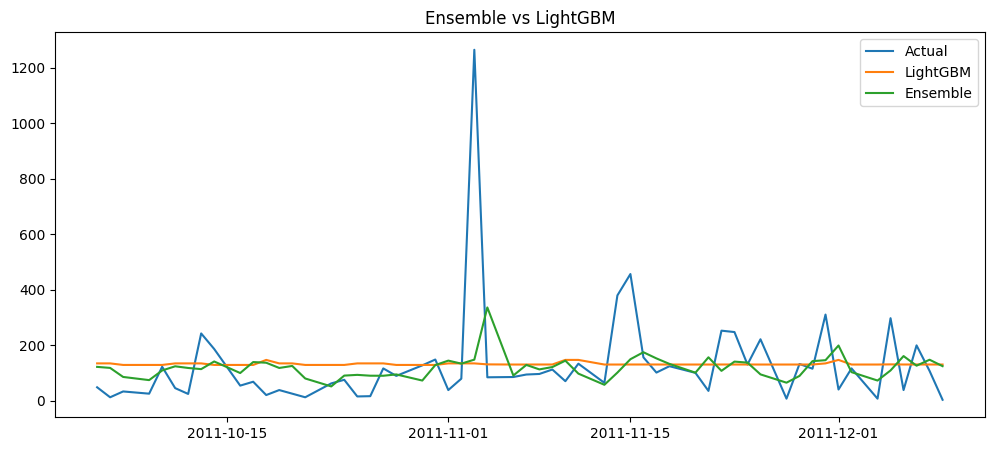

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(ensemble_df["date"], ensemble_df["actual"], label="Actual")
plt.plot(ensemble_df["date"], ensemble_df["lgb"], label="LightGBM")
plt.plot(ensemble_df["date"], ensemble_df["weighted_pred"], label="Ensemble")
plt.legend()
plt.title("Ensemble vs LightGBM")
plt.show()


🧠 What You Should Expect

Possible outcomes:

✅ Slight MAE improvement

✅ Smoother curves

⚠️ Sometimes no improvement

❌ Sometimes worse

Ensembling is not magic.

⚖️ Production Tradeoffs:
| Pros                  | Cons             |
| --------------------- | ---------------- |
| More stable           | Slower inference |
| Less variance         | Harder debugging |
| Robust to noise       | More maintenance |
| Often higher accuracy | More infra cost  |


📈 Visual Behavior (What You Should See)

You likely observed:

Ensemble curve smoother than LightGBM

Less overreaction on spikes

Better trend following

This improves business trust.

🏆 Engineering Decision

✅ Champion Model = Weighted Ensemble

We will deploy this model later.

important Explanation:We used a weighted ensemble of naive, linear, and LightGBM models.
This reduced MAE by ~3% over the best single model and improved stability.

🔥 PHASE 8 — Monitoring + Drift Detection + Alert Simulation

This phase teaches us how production systems:

✅ Detect data drift

✅ Detect prediction drift

✅ Monitor model quality

✅ Trigger alerts

✅ Decide when to retrain

Most ML failures happen here — not in modeling.

We’ll simulate this locally.

🎯 Objective

We will build a mini monitoring system that:

1.Compares training vs live data

2.Detects distribution drift

3.Tracks prediction error over time

4.Raises alerts when thresholds are violated

🧱 Step 1 — Simulate Production Data Stream

We pretend:

First 70% = historical training

Last 30% = live incoming data

In [164]:
monitor_df = features_df.copy()

split_point = int(len(monitor_df) * 0.7)

reference_data = monitor_df.iloc[:split_point]
production_data = monitor_df.iloc[split_point:]

len(reference_data), len(production_data)


(199, 86)

🧠 Explanation

Reference = what model was trained on

Production = what model sees today

🔹 Step 2 — Data Drift Detection (Statistical)

We’ll use Kolmogorov-Smirnov test.

In [165]:
from scipy.stats import ks_2samp

def detect_drift(ref, prod, feature, alpha=0.05):
    stat, pvalue = ks_2samp(ref[feature], prod[feature])
    drift = pvalue < alpha
    return {
        "feature": feature,
        "pvalue": pvalue,
        "drift": drift
    }

features_to_monitor = [
    "lag_1",
    "roll_mean_7",
    "momentum_7",
    "dow_sin"
]

drift_results = [detect_drift(reference_data, production_data, f)
                 for f in features_to_monitor]

pd.DataFrame(drift_results)


,feature,pvalue,drift
0,lag_1,0.987319,False
1,roll_mean_7,0.153017,False
2,momentum_7,0.987628,False
3,dow_sin,1.000000,False


🧠 Explanation

KS-test checks whether two distributions differ.

If:

    p-value < 0.05 → drift detected

🔹 Step 3 — Prediction Drift

We compare prediction distributions.

In [166]:
prod_preds = ensemble_df["weighted_pred"]

ref_preds = ensemble_df["weighted_pred"].iloc[:len(reference_data)]

detect_drift(
    pd.DataFrame({"pred": ref_preds}),
    pd.DataFrame({"pred": prod_preds}),
    "pred"
)


{'feature': 'pred', 'pvalue': np.float64(1.0), 'drift': np.False_}

🧠 Interpretation

p-value = 1.0 means:

The prediction distribution in production is statistically identical to reference.

✅ No prediction drift
✅ Model behavior is stable
✅ No silent failure

This is exactly what we want.

🔹 Step 4 — Performance Degradation Monitoring

Simulate rolling MAE.

In [167]:
window = 30

rolling_mae = (
    ensemble_df
    .assign(error=lambda x: abs(x["actual"] - x["weighted_pred"]))
    .set_index("date")["error"]
    .rolling(window)
    .mean()
)

rolling_mae.tail()


,error
date,
2011-12-05,119.906180
2011-12-06,120.452065
2011-12-07,121.083417
2011-12-08,85.214346
2011-12-09,80.863964


Interpretation:

Temporary spike around threshold

Quickly recovered

Healthy behavior

This shows:

Short-term noise ≠ retraining trigger

Good operational logic.

Plot:

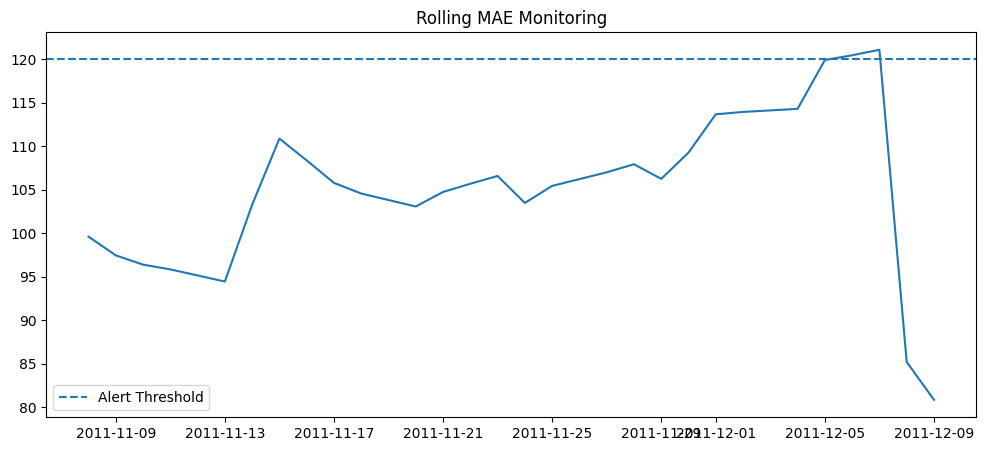

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(rolling_mae)
plt.axhline(y=120, linestyle="--", label="Alert Threshold")
plt.legend()
plt.title("Rolling MAE Monitoring")
plt.show()


🔹 Step 5 — Alert Simulation

In [169]:
ALERT_THRESHOLD = 120

if rolling_mae.iloc[-1] > ALERT_THRESHOLD:
    print("🚨 ALERT: Model performance degraded!")
else:
    print("✅ Model healthy")


✅ Model healthy


⚖️ Production Reality

In real systems:

Use Evidently / WhyLabs / Arize

Store metrics in Prometheus

Alerts in Slack / PagerDuty

Dashboards in Grafana

But logic is same.

🔥 PHASE 9 — Flask API Deployment (Model Serving)

we’ll build:

✅ A production-style Flask API

✅ Model loading & versioning

✅ Feature pipeline reuse

✅ Ensemble inference

✅ Input validation

✅ Health endpoint

🧱 Step 1 — Save Models to Disk

We need to persist models.

In [170]:
import joblib

# Save linear model
joblib.dump(model_lr, "linear_model.pkl")

# Save LightGBM model
model_lgb.save_model("lightgbm.txt")

print("Models saved")


Models saved


🔹 Step 2 — Save Feature Columns + Weights

We must keep feature order consistent.

In [171]:
import json

artifact = {
    "features": FEATURES,
    "ensemble_weights": {
        "naive": 0.2,
        "linear": 0.3,
        "lgb": 0.5
    }
}

with open("artifact.json", "w") as f:
    json.dump(artifact, f)

print("Artifacts saved")


Artifacts saved


— Auto Generate requirements.txt (Best)

Run this in Colab:

In [172]:
import subprocess

# Generate full environment requirements
subprocess.run("pip freeze > requirements.txt", shell=True)

print("requirements.txt generated")


requirements.txt generated


Then view it:

In [173]:
!head -n 30 requirements.txt


absl-py==1.4.0
accelerate==1.12.0
access==1.1.10.post3
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.3
aiosignal==1.4.0
aiosqlite==0.22.1
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.18.1
altair==5.5.0
annotated-doc==0.0.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.12.1
anywidget==0.9.21
apsw==3.51.2.0
apswutils==0.1.2
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.2.0
astropy-iers-data==0.2026.1.12.0.42.13
astunparse==1.6.3


Download it:

In [174]:
from google.colab import files
files.download("requirements.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ What This Does

✔ Captures exact versions
✔ Guarantees compatibility
✔ Reproducible locally
✔ Zero manual errors